In [17]:
import pandas as pd
import glob
import os 
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import glob
import random

from tqdm import tqdm

In [2]:
tr = pd.read_csv("../data/train.csv")
trl = pd.read_csv("../data/train_localizers.csv")


In [3]:
import multiprocessing
import os
import time

In [47]:
def getsz(uid):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))
    img = pydicom.dcmread(files[0])
    if len(img.pixel_array.shape) == 3:
        return uid,img.pixel_array.shape[1],img.pixel_array.shape[2]
    
    return uid,img.pixel_array.shape[0],img.pixel_array.shape[1]

In [48]:

uids = list(tr["SeriesInstanceUID"])

with multiprocessing.Pool(processes=16) as pool:

    data = pool.map(getsz, uids)


/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(


In [49]:
szdf = pd.DataFrame({ "SeriesInstanceUID": [s[0] for s in data]
                    , "height": [s[1] for s in data]
                    , "width": [s[2] for s in data]
                    }
                   )

In [50]:
szdf.iloc[:,1:].describe()

,height,width
count,4405.000000,4405.000000
mean,507.320091,494.674461
std,113.190796,113.196997
min,192.000000,176.000000
25%,512.000000,512.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,1024.000000,1024.000000


In [58]:
import numpy as np

In [65]:
def viewinstance(uid,level, around):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))

    lvls = []
    for f in files:
        lvls.append((int(pydicom.dcmread(f).InstanceNumber),f))

    lvls = sorted(lvls)
    print(len(lvls))

    lvls = [*filter(lambda lvl:  abs(lvl[0] - level) <= around, lvls)]
    
    for lvl,f in lvls:
        img = pydicom.dcmread(f).pixel_array
        print(img.shape,np.min(img), np.max(img),img.dtype)
        fig, ax = plt.subplots()
        if len(img.shape) > 2:
            continue
        ax.imshow(img)
        # rect = patches.Rectangle((c["x"]-10, c["y"]-10), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        plt.show()
    
    

188
(512, 512) 0 362 int16


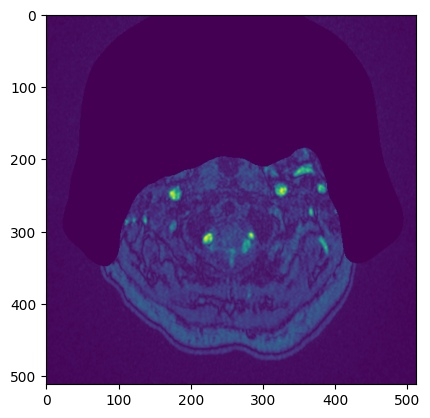

In [69]:
viewinstance(szdf.iloc[0,0], 0, 1)

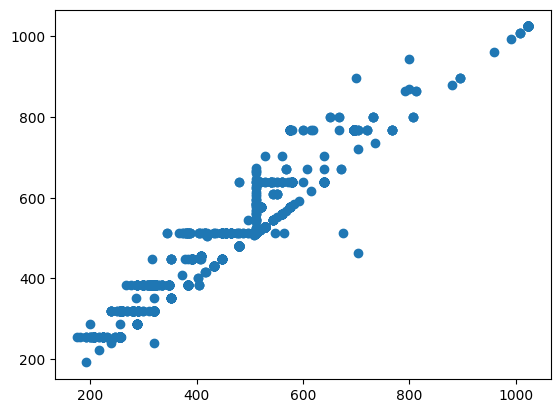

In [52]:
plt.scatter(x=szdf["width"],y=szdf["height"])
# plt.



1. Filter the uids that we don't wanna use
2. Create 5-Folds
3. create volumes

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import ast
import pydicom

import multiprocessing

from pathlib import Path
import os
import pydicom
import cv2

/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


In [2]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [3]:
ignore_uids = [
    "1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068",
    "1.2.826.0.1.3680043.8.498.35204126697881966597435252550544407444",
    "1.2.826.0.1.3680043.8.498.87480891990277582946346790136781912242"
] + list(mf_dicom_uids["SeriesInstanceUID"])
train_df = train_df[~train_df["SeriesInstanceUID"].isin(ignore_uids)].reset_index(drop=True)

In [4]:
train_df["fold_id"] = 0

In [5]:
sgkf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(sgkf.split(train_df["SeriesInstanceUID"], train_df["Aneurysm Present"])):
    train_df.loc[test_index, "fold_id"] =  i 

In [6]:
label_df["x"] = [s['x'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["y"] = [s['y'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["z"] = -1



In [7]:
def calculate_z_coord():
    for idx,rowdf in label_df.iterrows():
        uid,f = rowdf["SeriesInstanceUID"],rowdf["SOPInstanceUID"]

        label_df.loc[idx,'z'] = int(pydicom.dcmread(f"../data/series/{uid}/{f}.dcm").InstanceNumber) - 1
        
    

In [8]:
calculate_z_coord()

In [9]:
del label_df["coordinates"]

In [10]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,162
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,453
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,112
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,177
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,46


In [11]:
def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float) -> np.ndarray:
    """Apply DICOM windowing"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-7)
    return (img * 255).astype(np.uint8)

def get_windowing_params(modality: str) -> tuple[float, float]:
    """Get appropriate windowing for different modalities"""
    windows = {
        'CT': (40, 80),
        'CTA': (50, 350),
        'MRA': (600, 1200),
        'MRI': (40, 80),
    }
    return windows.get(modality, (40, 80))



In [12]:
IMG_SIZE = 512
FACTOR = 3

In [15]:
def process_slice(img,ds):
    modality = getattr(ds, 'Modality', 'CT')
    
    # Apply rescale if available
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept
        
    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img



def process_dicom_series(uid: str) -> tuple[np.ndarray, dict]:
    """Process a DICOM series and extract metadata"""
    series_path = Path(f"../data/series/{uid}")
    
    # Find all DICOM files
    all_filepaths = []
    for root, _, files in os.walk(series_path):
        for file in files:
            if file.endswith('.dcm'):
                all_filepaths.append(os.path.join(root, file))
    all_filepaths.sort()
    
    if len(all_filepaths) == 0:
        print(f"No DCM files found for {uid}")
        return
        
    # Process DICOM files
    slices = []
    modality = None
    instance_numbers = []
    
    for i, filepath in enumerate(all_filepaths):
        ds = pydicom.dcmread(filepath, force=True)
        
        # print(ds.InstanceNumber)
        img = ds.pixel_array.astype(np.float32)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                imgs = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)]
            else:
                imgs = img

        else:
            imgs = [img]
            
        for img in imgs:
            if hasattr(ds, "InstanceNumber"):
                instance_numbers.append(ds.InstanceNumber)
            
            if hasattr(ds, "ImagePositionPatient"):
                slices.append((ds.ImagePositionPatient[-1],process_slice(img,ds)))
            elif hasattr(ds, "InstanceNumber"):
                slices.append((int(ds.InstanceNumber),process_slice(img,ds)))
            else:
                slices.append((0,process_slice(img,ds)))


    instance_numbers = sorted(instance_numbers)
    start_instance_number = instance_numbers[0] - 1


    slices = sorted(slices, key = lambda x: x[0])
    
    volume = np.array([slice[-1] for slice in slices])

    selected_idxs = [*range(0,volume.shape[0],FACTOR)]

    uid_label_df = label_df[label_df["SeriesInstanceUID"] == uid]

    required_idxs = [idx - start_instance_number for idx in list(uid_label_df["z"])]
    
    if len(required_idxs) != 0:
        final_idxs = sorted(list(set(selected_idxs).union(required_idxs)))
    else:
        final_idxs = sorted(selected_idxs)

    if len(required_idxs) != 0:
        mapped_idxs = [final_idxs.index(idx) for idx in required_idxs]
        # label_df.loc[label_df["SeriesInstanceUID"] == uid,'z'] = mapped_idxs
    
        return volume[final_idxs], mapped_idxs
    else:
        return volume[final_idxs], []
        

In [16]:
from tqdm import tqdm

In [17]:


# Assume train_df and process_dicom_series are defined elsewhere
# For example:
# train_df = pd.read_csv("path/to/your/train.csv")
# def process_dicom_series(uid):
#     # Your actual processing logic for a single series UID
#     # ...
#     return np.random.rand(10, 10) # Placeholder for the processed volume


# 1. Define a worker function
# This function contains the logic that was inside your for-loop.
# It takes one item (a UID) and performs the full task for it.
def process_and_save(uid):
    """Processes a single DICOM series and saves it to a .npz file."""
    try:
        vol, mapped_idx = process_dicom_series(uid)
        np.savez_compressed(f"../data/processed/{uid}.npz", vol=vol) # Use savez_compressed for smaller files
        return {"uid": uid, "mapped_idx": mapped_idx}, None # Return UID on success
    except Exception as e:
        return {"uid": uid, "mapped_idx": []}, e # Return UID and the error if something fails

# Get the list of unique UIDs to process
uids_to_process = train_df["SeriesInstanceUID"].unique()
total_uids = len(uids_to_process)

print(f"Starting processing for {total_uids} UIDs...")

# 2. Set up the multiprocessing Pool
# os.cpu_count() is a good default for the number of parallel processes.
with multiprocessing.Pool(processes=16) as pool:
    
    # 3. Use imap_unordered with tqdm for a progress bar
    # imap_unordered is efficient because it yields results as they finish.
    # tqdm wraps the iterator to show progress.
    results = list(tqdm(pool.imap_unordered(process_and_save, uids_to_process), total=total_uids))

print("\nProcessing complete.")



Starting processing for 4260 UIDs...


/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame60 [09:20<02:46,  4.13it/s]
  warn_and_log(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4260/4260 [11:11<00:00,  6.34it/s]


Processing complete.


In [20]:
for r in results:
    data = r[0]
    if len(data["mapped_idx"]) != 0:
        label_df.loc[label_df["SeriesInstanceUID"] == data["uid"],'z'] = data["mapped_idx"]

In [21]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,54
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,151
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,38
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,59
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,16


In [22]:
label_df.to_csv("../data/processed/label_df.csv", index=False)
train_df.to_csv("../data/processed/train_df.csv", index=False)